# Competição ML @SBS/DAA - 5ª Edição (2022/2023)

Esta competição está relacionada com o Trabalho Prático de Grupo das UCs do perfil Machine Learning: Fundamentos e Aplicações da Uminho e da UC Dados e Aprendizagem Automática, tendo, como destinatários, alunos do Mestrado em Engenharia Informática, do Mestrado em Matemática e Computação, e do Mestrado em Engenharia de Sistemas.

# Descrição da Competição
A previsão da quantidade de incidentes rodoviários é um conhecido problema de características estocásticas, não-lineares. Tem, contudo, aparecido na literatura um conjunto de modelos que demonstram um potencial assinalável neste tipo de previsões. Com isso em consideração, foi construído um dataset que contém dados referentes à quantidade e características dos incidentes rodoviários que ocorreram na cidade de Guimarães em 2021 (o dataset cobre um período que vai desde o dia 01 de Janeiro de 2021 até ao dia 31 de Dezembro do mesmo ano).

Com esta competição espera-se que os alunos desenvolvam e otimizem modelos de Machine Learning que sejam capazes de prever o número de incidentes rodoviários que irão acontecer na cidade de Guimarães a uma determinada hora.

## Imports utilizados

In [19]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

# Instalar as dependências necessárias

In [20]:
!pip3 install scipy
!pip3 install pydotplus
!pip3 install graphviz

Unable to create process using 'C:\Users\Henrique Fernandes\.conda\envs\envNAME\python.exe "C:\Users\Henrique Fernandes\.conda\envs\envNAME\Scripts\pip3-script.py" install scipy'
Unable to create process using 'C:\Users\Henrique Fernandes\.conda\envs\envNAME\python.exe "C:\Users\Henrique Fernandes\.conda\envs\envNAME\Scripts\pip3-script.py" install pydotplus'


Unable to create process using 'C:\Users\Henrique Fernandes\.conda\envs\envNAME\python.exe "C:\Users\Henrique Fernandes\.conda\envs\envNAME\Scripts\pip3-script.py" install graphviz'


### Mudar o modo que a Interactive shell imprime as variáveis

In [21]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

## Carregar os dataset de treino e de teste

In [22]:
%run "datasets/parse.ipynb"
train_df = parse_train("")
test_df = parse_test("")

#### Seed utilizada

In [23]:
SEED = 2023

## Preparação de Dados

In [24]:
# Não tratar outliers de 'affected_roads', 'hour', 'day', 'month', 'weekday', 'weekend', 'holiday'
numeric_columns = ['Hora', 'Normal (kWh)', 'Horario Economico (kWh)', 'Autoconsumo (kWh)', 'temp','feels_like','temp_min','temp_max','pressure','humidity', 'wind_speed','clouds_all','rain_1h']


### Converter features categóricas para valores numéricos

In [25]:
categorical_to_numerical = {
    'Injecao na rede (kWh)': {
        'None': 0,
        'Low': 1,
        'Medium': 2,
        'High':3,
        'Very High':4
    },
    'weather_description': {
        'overcast clouds': 0,
        'scattered clouds': 1,
        'few clouds': 2,
        'sky is clear': 3,
        'broken clouds': 4,
        'light rain': 5,
        'moderate rain': 6,
        'heavy intensity rain':7
    }
}

In [26]:
from pandas import DataFrame
from sklearn.preprocessing import KBinsDiscretizer
import statistics
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox


#### Funções Auxiliares

In [27]:
### Criar 5 bins para a variável hour
def create_bins_for_hour(df: DataFrame):
    est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
    est.fit(df['hour'].to_frame())
    df['hour'] = est.transform(df['hour'].to_frame())
    return df['hour']

### Verificar se a data se refere a um feriado português.
def is_it_holiday(month: int, day: int):
    is_holiday = 0
    for date in holidays_in_guimaraes['date']:
        date_splitted = str(date).split('-')
        month_holiday = date_splitted[1]
        day_holiday = date_splitted[2]
        if str(day) == day_holiday and str(month) == month_holiday:
            is_holiday = 1
            break
    return is_holiday

In [28]:
def decision_tree_data_preparation(df: DataFrame,test_or_train) -> DataFrame:

    prep_df= df
    prep_df['rain_1h'] = prep_df['rain_1h'].replace('', '0')
    prep_df['rain_1h'] = pd.to_numeric(prep_df['rain_1h'])
            
    ### Converter as features categoricas em numericas
    prep_df.replace(categorical_to_numerical, inplace=True)

    ### Extrair a hora e dia da semana da feature 'record_date'
    record_date = pd.DatetimeIndex(prep_df['Data'])

    prep_df['Month'] = record_date.month

    dropped_columns = ['grnd_level','sea_level','dt','Data','city_name']
    prep_df = prep_df.drop(dropped_columns, axis=1)

    prep_df.loc[(prep_df['Hora'] < 6) & (prep_df['Hora'] > 21), 'Injecao na rede (kWh)'] = 0

    ### Normalizaçao
    prep_df[numeric_columns] = prep_df[numeric_columns].apply(lambda x: (x - x.min()) / (x.max() - x.min()))    

   
    ### Limites superior e inferior (sem outliers) dos diagramas de caixa
    whiskers = []
    for num in numeric_columns:
        Q1 = prep_df[num].quantile(0.25)
        Q3 = prep_df[num].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        whiskers.append((num,lower,upper))

    ### Tratar os outliers das features numéricas:
    ### Substituir os valores dos outliers pela mediana
    if(train_test_split == "train"):
        for num, lower, upper in whiskers:
            prep_df = prep_df[(prep_df[num] >= lower) & (prep_df[num] <= upper)]

    return prep_df

### Divisão do dataset de treino em dados de treino e de teste

In [29]:
from sklearn.model_selection import train_test_split

X = decision_tree_data_preparation(train_df,"train")

# Separate the target variable from the input features
y = X['Injecao na rede (kWh)']
X.drop(columns=['Injecao na rede (kWh)'], inplace=True)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

### Modelo de Árvore de decisão

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Create a Decision Tree model
clf = DecisionTreeClassifier()
# clf = RandomForestClassifier()
# clf = LogisticRegression(C=0.1)

"""
# Evaluate the model using 10-fold cross-validation
scores = cross_val_score(estimator=clf, X=X, y=y, cv=20)

# Print the mean and standard deviation of the scores
#print(f'Mean accuracy: {scores.mean():.3f}')
#print(f'Standard deviation: {scores.std():.3f}')

clf.fit(X_train, y_train)
"""

# Fit the model to the training data
clf.fit(X_train, y_train)

# Evaluate the model using cross-validation
#scores = cross_val_score(clf, X, y, cv=200, scoring='f1_micro')

# Print the mean and standard deviation of the cross-validation scores
#print("F1 score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))


"\n# Evaluate the model using 10-fold cross-validation\nscores = cross_val_score(estimator=clf, X=X, y=y, cv=20)\n\n# Print the mean and standard deviation of the scores\n#print(f'Mean accuracy: {scores.mean():.3f}')\n#print(f'Standard deviation: {scores.std():.3f}')\n\nclf.fit(X_train, y_train)\n"

DecisionTreeClassifier()

#### Exportar o gráfico da árvore de decisão

In [31]:
"""
from six import StringIO
from IPython.display import Image
import pydotplus

prep_df = decision_tree_data_preparation(train_df)
prep_df.drop(columns=['incidents'], inplace=True)

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,feature_names = prep_df.columns,class_names=['0','1','2','3','4'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('incidents-decision-tree.png')
Image(graph.create_png())
"""

"\nfrom six import StringIO\nfrom IPython.display import Image\nimport pydotplus\n\nprep_df = decision_tree_data_preparation(train_df)\nprep_df.drop(columns=['incidents'], inplace=True)\n\ndot_data = StringIO()\nexport_graphviz(clf, out_file=dot_data,\n                filled=True, rounded=True,\n                special_characters=True,feature_names = prep_df.columns,class_names=['0','1','2','3','4'])\n\ngraph = pydotplus.graph_from_dot_data(dot_data.getvalue())\ngraph.write_png('incidents-decision-tree.png')\nImage(graph.create_png())\n"

#### Obter as previsões

In [32]:
from sklearn.metrics import f1_score

# Make predictions on the test data
predictions = clf.predict(X_test)

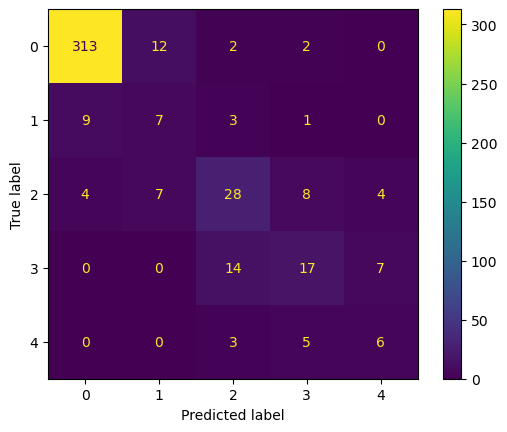

In [33]:
cm = confusion_matrix(y_test, predictions)
# TP FP
# FN TN
disp = ConfusionMatrixDisplay(cm)

disp.plot()

In [34]:
accuracy_score(y_test, predictions)
# (TP + TN) / (TP + FP + FN + TN)

precision_score(y_test, predictions, average='micro')
# TP / (TP + FP)

recall_score(y_test, predictions, average='micro')
# TP / (TP + FN)

0.8207964601769911

0.8207964601769911

0.8207964601769911

# Reading the test dataset

In [35]:
X = decision_tree_data_preparation(train_df,"test")
X.drop(columns=['Injecao na rede (kWh)'], inplace=True)


# Getting the predictions

In [36]:
predictions = clf.predict(X)

predictions_df = pd.DataFrame(predictions)

numerical_to_categorical = {
    0: {
        0 : 'None',
        1 : 'Low',
        2 : 'Medium',
        3 : 'High',
        4 : 'Very High'
    }
}

predictions_df.replace(numerical_to_categorical, inplace=True)

predictions_df.index += 1

predictions_df.to_csv("submission.csv", header=['Result'], index_label='RowId')